# Importação das bibliotecas

In [3]:
import pandas as pd
from IPython.core.interactiveshell import re
import cv2
import numpy as np
from src import ocr
from matplotlib import pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Carregamento da imagem

In [4]:
img_number = 1
img_name = f'Cod ({img_number})'
img_inicial_path = f'./Codigos/{img_name}.jpg'
img_inicial = cv2.imread(img_inicial_path)

# Função para mostrar as imagens com título
Adaptada do código encontrado no github

https://github.com/wjbmattingly/ocr_python_textbook/blob/main/02_02_working%20with%20opencv.ipynb

In [5]:
def show(img_path, title):
    dpi = 50
    img_data = plt.imread(img_path)
    if len(img_data.shape) == 3:
        height, width, depth = img_data.shape
    else:
        height, width = img_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img_data, cmap='gray')

    plt.title(title)
    plt.show()

# Função que salva a imagem como arquivo
Salva na pasta de Resultados e chama a função de exibição

In [6]:
def display(img, img_name):
    img_path = f'./Resultado/img_{img_name}.png'
    cv2.imwrite(img_path, img)
    show(img_path, f"Imagem {img_name}")

# Função que salva a imagem como arquivo
Salva na pasta de Outputs, para ser usada no relatório

In [7]:
def save_results(img, img_name, img_number):
    img_path = f'./Outputs/Cod ({img_number}) - {img_name}.png'
    cv2.imwrite(img_path, img)

## Imagem Inicial

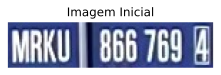

In [8]:
display(img_inicial, "Inicial")

## Imagem redimensionada

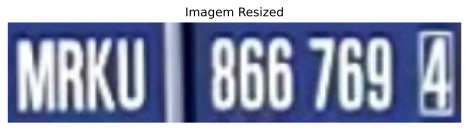

In [9]:
scale_percent = 220 # percent of original size
width = int(img_inicial.shape[1] * scale_percent / 100)
height = int(img_inicial.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
img_resized = cv2.resize(img_inicial, dim, interpolation=cv2.INTER_LINEAR)
display(img_resized, "Resized")

## Filtro de Binarização OTSU
Melhor resultado para imagens com contraste, obtida da documentação do OpenCV

https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization

In [10]:
def otsu_threshold(src_img):
    """ NOT expected to return white text on black background"""
    gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    _, thresh_img1 = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh_img2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 17)
    return cv2.bitwise_and(thresh_img1, thresh_img2)

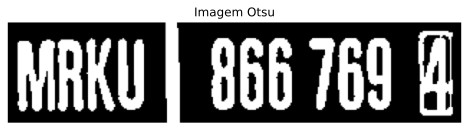

In [11]:
thresh = otsu_threshold(img_resized)
display(thresh, "Otsu")

## Função que confere se a imagem é preto e branco
Garante que o resultado do filtro de binarização tenha letra branca e fundo preto, adaptado do código encontrado no github

https://github.com/lamnguyenkhoa/container-code-recognition/blob/main/src/code_image_cleaner.py#L104

In [12]:
def make_sure_it_bbwt(thresh_img, depth=2):
    """ Make sure the thresh img has white text on black background """
    im_h, im_w = thresh_img.shape[:2]
    
    # Calculate the pixel value of image border
    total_pixel_value = np.sum(thresh_img)
    center_img = thresh_img[depth:im_h - depth, depth:im_w - depth]
    center_pixel_value = np.sum(center_img)
    border_bw_value = (total_pixel_value - center_pixel_value) / (im_h * im_w - center_img.size)

    # If True mean it is not bbwt, and thresh must be invert
    if border_bw_value > 127:
        cv2.bitwise_not(thresh_img, thresh_img)

In [13]:
make_sure_it_bbwt(thresh)

## Função que remove ruídos

In [14]:
def remove_noise(thresh):
    mask = np.ones(thresh.shape[:2], dtype="uint8") * 255
    return cv2.bitwise_and(thresh, thresh, mask=mask)

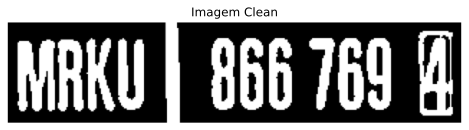

In [15]:
img_clean = remove_noise(thresh)
display(img_clean, "Clean")

## Funções de erosão, dilatação, abertura e fechamento
Utilizadas para verificar qual delas melhor se adequa ao problema

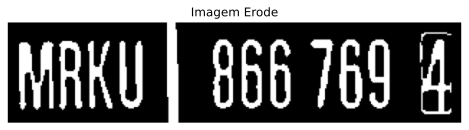

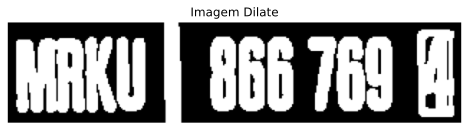

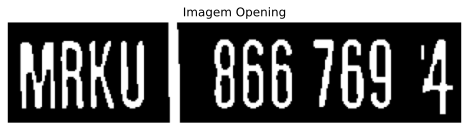

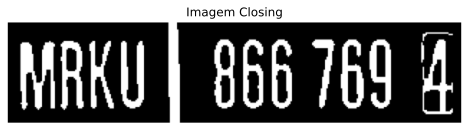

In [16]:
kernel = np.ones((3, 3), np.uint8)
kernel2 = np.ones((3, 2), np.uint8)

img_erode = cv2.erode(img_clean, kernel, iterations=1)
display(img_erode, "Erode")

img_dilate = cv2.dilate(img_clean, kernel, iterations=1)
display(img_dilate, "Dilate")

img_opening = cv2.morphologyEx(img_erode, cv2.MORPH_OPEN, kernel2)
display(img_opening, "Opening")

img_closing = cv2.morphologyEx(img_erode, cv2.MORPH_CLOSE, kernel2)
display(img_closing, "Closing")

## Exibição das imagens inicial e final

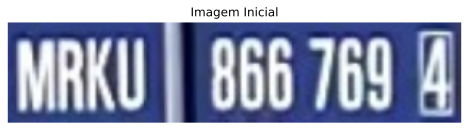

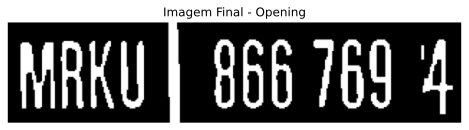

In [17]:
display(img_resized, "Inicial")
img_final = img_opening
name = "Opening"
result = ocr.find_code_in_image(img_final)

if len(result) < 11:
    img_final = img_erode
    name = "Erode"
    result = ocr.find_code_in_image(img_final)

display(img_final, f"Final - {name}")


## Resultado do OCR

In [18]:
if len(result) < 13 or len(result) > 12:
    print("Código cortado ou não lido corretamente (de acordo com o padrão BIC de containers)")  # https://en.wikipedia.org/wiki/ISO_6346

print(result)

Código cortado ou não lido corretamente (de acordo com o padrão BIC de containers)
MRKU 866769 4


## Salva o resultado do OCR em uma planilha

In [19]:
raw_data = {'file': [img_name], 'container_code': [result]}
df = pd.DataFrame(raw_data, columns=['file', 'container_code'])
df.to_csv('data.csv')

df

,file,container_code
0,Cod (1),MRKU 866769 4


## Salva as imagens inicial e final em uma pasta para serem usadas no relatório

In [20]:
save_results(img_resized, "Inicial", img_number)
save_results(img_final, f"Final - {name}", img_number)